# Food Classification with Food-101 Dataset

In this notebook, we will going to apply transfer learning to classify our modified Food-101 Dataset. We will evaluate three activation functions: Sigmoid, Relu, and Tanh respectively, and compare the results. Besides showing the testing and validation results, we will upload photos taken in our real life to do experiment on our network. Finally, we will add calories information and display calories information along with the image. 

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable

import glob
import os
import matplotlib.pyplot as plt
import torchvision.models as models
import cv2
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np

import timeit

## I.Network
Taking the pretrained Alexnet data, we added three fully connected linear layers to classify image into 55 classes. The inputs are a tensor with feature extrated by Alexnet, and the output is a softmax layer giving the probabilities of the 55 classes. We experimented on three different activation functions to explore which works better for our dataset.

In [0]:
class Classifier_sigmoid(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(Classifier_sigmoid, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, hidden_layers)
        self.fc3 = nn.Linear(hidden_layers, output_size)
    
    def forward(self,data):
        x = torch.sigmoid(self.fc1(data))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x,dim = 1)

In [0]:
class Classifier_relu(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(Classifier_relu, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, hidden_layers)
        self.fc3 = nn.Linear(hidden_layers, output_size)
    
    def forward(self,data):
        x = F.relu(self.fc1(data))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x,dim = 1)

In [0]:
class Classifier_tanh(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(Classifier_tanh, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, hidden_layers)
        self.fc3 = nn.Linear(hidden_layers, output_size)
    
    def forward(self,data):
        x = torch.tanh(self.fc1(data))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x,dim = 1)

##II.Trainning and validating

### II-1. load in preprocessed data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#loading the preprocess pkl file
with open("drive/My Drive/CV Project/training_data_alexnet.pkl","rb") as f:
    training_data = pickle.load(f)
    random.shuffle(training_data)
    
with open("drive/My Drive/CV Project/test_data_alexnet.pkl","rb") as f:
    test_data = pickle.load(f)

### II-2 training loop starts

In [0]:
def chunk(data,batch_size):
    batches = []
    x = np.arange(len(data) // batch_size + 2)*batch_size
    for b,e in zip(x[0:-1],x[1:]):
        batches.append(data[b:e])
    return batches  

In [0]:
def encode_batch(minibatch):
    label_batch = []
    feature_batch_vector = []
    for label, feature in minibatch:
        label_batch.append(label)
        feature_batch_vector.append(feature.squeeze())
    return np.array(label_batch), np.array(feature_batch_vector)

In [0]:
# Function to validate if the prediction is accurate
# return accuracy rate for 1) top prediction is accurate; 2) top 5 predictions contains correct label
def validate_topn(test_data,net):
    correct = 0
    top_five_acc = 0
    first_acc = 0

    length = len(test_data)

    for label, feature in test_data:
        x = Variable(torch.FloatTensor(feature)).cuda()
        output = net(x)
        predict_probs = output.cpu().data.numpy()
        
        top5_index = np.argsort(predict_probs).squeeze()[-5:]
        top1_index = np.argsort(predict_probs).squeeze()[-1:]

        if label in top5_index:
            top_five_acc += 1
            if label == top1_index:
                first_acc += 1

    top_five_acc = top_five_acc / length
    first_acc = first_acc / length
    return top_five_acc,first_acc 

In [0]:
# Main loop for network training
def classify(classifier,learningRate = 0.0001,epoch = 100):
  if classifier == "sigmoid":
    net = Classifier_sigmoid(4096,2048,55)
  elif classifier == "relu":
    net = Classifier_relu(4096,2048,55)
  elif classifier == "tanh":
    net = Classifier_tanh(4096,2048,55)

  learning_rate = learningRate
  optimizer = optim.Adam(net.parameters(), lr=learning_rate )
  loss = nn.CrossEntropyLoss()
  training_batches = chunk(training_data,128)

  net.train()
  net.cuda()
  max_epoch = epoch
  train_accuracy_5_class = []
  train_accuracy_1_class = []
  train_loss = []
  test_accuracy_5_class = []
  test_accuracy_1_class = []
  
  start = timeit.default_timer()

  for ep in range(max_epoch):
      net.train()
      err_sum = 0 
      for minibatch in training_batches:
          feature_label, feature_vector = encode_batch(minibatch)
          feature_tensor = Variable(torch.FloatTensor(feature_vector)).cuda()
          feature_label = Variable(torch.LongTensor(feature_label)).cuda()
          output = net(feature_tensor)
          error = loss(output, feature_label)
          err_sum += error
          optimizer.zero_grad()
          error.backward()
          optimizer.step()
      
      avg_err = err_sum.cpu().data.numpy()/ len(minibatch)
      train_loss.append(avg_err)

      net.eval()

      #validating trainning result and testing result
      train_5_class, train_1_class = validate_topn(training_data,net)
      test_5_class, test_1_class = validate_topn(test_data,net)

      train_accuracy_5_class.append(train_5_class)
      test_accuracy_5_class.append(test_5_class)
      train_accuracy_1_class.append(train_1_class)
      test_accuracy_1_class.append(test_1_class)

      print ("epoch: ", ep)
      print ("acc using 1 predcition: train -", train_1_class, " test -", test_1_class)
      print ("acc using 5 predcition: train -", train_5_class, " test -", test_5_class)
      print ("---------------------------------------------")
  
  stop = timeit.default_timer()
  print('Total execution time: ', stop - start)  

  fileName = "drive/My Drive/CV Project/" + classifier + "_data.plk"
  with open(fileName,"wb") as f:
    pickle.dump(net,f)
  print ("network data save to " + fileName)
  return train_loss,train_accuracy_1_class,test_accuracy_1_class,train_accuracy_5_class,test_accuracy_5_class

##III.Performance

### III-1 Classify using three activation functions
We feed our preprocessed data into three networks, and evaluate the results

In [0]:
S_lost,S_train1,S_test1,S_train5,S_test5 = classify("sigmoid",learningRate=0.0005,epoch=100)

epoch:  0
acc using 1 predcition: train - 0.10596877424359968  test - 0.10145454545454545
acc using 5 predcition: train - 0.19552463149728472  test - 0.196
---------------------------------------------
epoch:  1
acc using 1 predcition: train - 0.1602744375484872  test - 0.14952727272727273
acc using 5 predcition: train - 0.2391388673390225  test - 0.24087272727272727
---------------------------------------------
epoch:  2
acc using 1 predcition: train - 0.17739041892940263  test - 0.1610181818181818
acc using 5 predcition: train - 0.26907971295577965  test - 0.2722909090909091
---------------------------------------------
epoch:  3
acc using 1 predcition: train - 0.20277346780449962  test - 0.18072727272727274
acc using 5 predcition: train - 0.3011297517455392  test - 0.3004363636363636
---------------------------------------------
epoch:  4
acc using 1 predcition: train - 0.228277734678045  test - 0.19614545454545454
acc using 5 predcition: train - 0.3221974398758728  test - 0.3208727

In [0]:
R_lost,R_train1,R_test1,R_train5,R_test5 = classify("relu",learningRate=0.0001,epoch=100)

epoch:  0
acc using 1 predcition: train - 0.21169511249030257  test - 0.2088
acc using 5 predcition: train - 0.32437936384794414  test - 0.3321454545454545
---------------------------------------------
epoch:  1
acc using 1 predcition: train - 0.23935705973622964  test - 0.22436363636363638
acc using 5 predcition: train - 0.34753200155159036  test - 0.35061818181818183
---------------------------------------------
epoch:  2
acc using 1 predcition: train - 0.2587034522885958  test - 0.2341090909090909
acc using 5 predcition: train - 0.3528898370830101  test - 0.35745454545454547
---------------------------------------------
epoch:  3
acc using 1 predcition: train - 0.27664371605896043  test - 0.2397090909090909
acc using 5 predcition: train - 0.35572633824670286  test - 0.3599272727272727
---------------------------------------------
epoch:  4
acc using 1 predcition: train - 0.2821955003878976  test - 0.23716363636363635
acc using 5 predcition: train - 0.36137509697439874  test - 0.3632

In [0]:
T_lost,T_train1,T_test1,T_train5,T_test5 = classify("tanh",learningRate=0.0001,epoch=100)

epoch:  0
acc using 1 predcition: train - 0.3183911947245927  test - 0.31134545454545454
acc using 5 predcition: train - 0.5197827773467805  test - 0.5363636363636364
---------------------------------------------
epoch:  1
acc using 1 predcition: train - 0.3828791698991466  test - 0.34705454545454545
acc using 5 predcition: train - 0.5888285492629945  test - 0.6051636363636363
---------------------------------------------
epoch:  2
acc using 1 predcition: train - 0.42787529092319626  test - 0.36414545454545455
acc using 5 predcition: train - 0.6112296353762606  test - 0.6250181818181818
---------------------------------------------
epoch:  3
acc using 1 predcition: train - 0.45444627618308764  test - 0.372
acc using 5 predcition: train - 0.6180178432893716  test - 0.6269818181818182
---------------------------------------------
epoch:  4
acc using 1 predcition: train - 0.47701706749418155  test - 0.372
acc using 5 predcition: train - 0.627521334367727  test - 0.6310545454545454
-------

### III-2 Visualize performance results
In the previous section, we've showed the trainning and testing results of our models. To briefly summarize the results, Tanh activation functions did a better job at our testing(or validation) image, reaching 80% accuracy for top 5 predictions within 100 episodes. While Relu did a worse job at both training accuracy and testing accuracy. In terms of execution time, tanh took more than twice of Relu and Sigmoid's execution time. However, in order to better classfy image and output corresponding calories, we will be using tanh activation functions in the following analysis. 


In [0]:
def plotAcc(train_loss,train_accuracy_1_class,test_accuracy_1_class,train_accuracy_5_class,test_accuracy_5_class):
  # visualize network results
  fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,4))

  ax1.plot(train_loss,label = 'training lost data')
  ax1.set_title('Lost Figure')

  ax2.plot(train_accuracy_1_class,label = '1 prediction')
  ax2.plot(train_accuracy_5_class,label = '5 prediction')
  ax2.set_title('Train Accuracy Figure')
  ax2.legend(loc = 'best')

  ax3.plot(test_accuracy_1_class,label = '1 prediction')
  ax3.plot(test_accuracy_5_class,label = '5 prediction')
  ax3.set_title('Test Accuracy Figure')
  ax3.legend(loc = 'best')

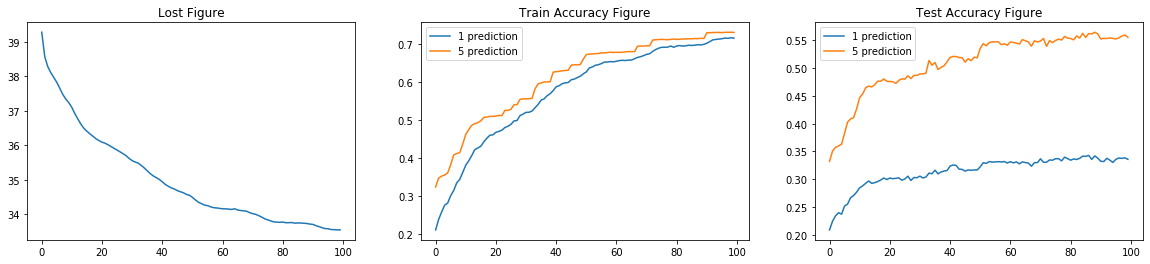

In [0]:
plotAcc(R_lost,R_train1,R_test1,R_train5,R_test5 )

Fig.1 Relu activation function accumulative loss figure and accuracy figure

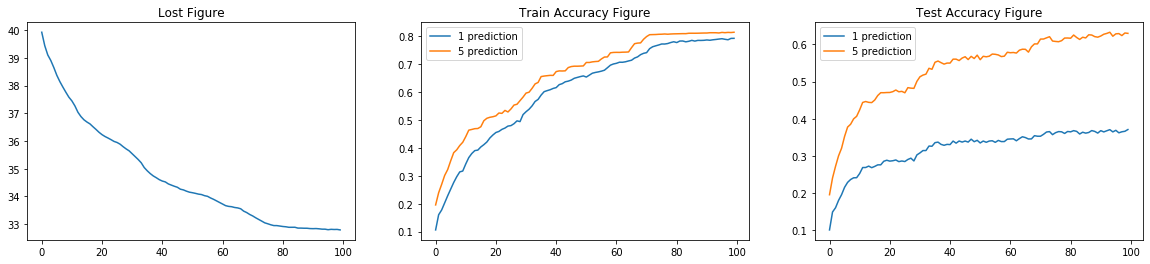

In [0]:
plotAcc(S_lost,S_train1,S_test1,S_train5,S_test5)

Fig2. Rigmoid activation function accumulative loss figure and accuracy figure

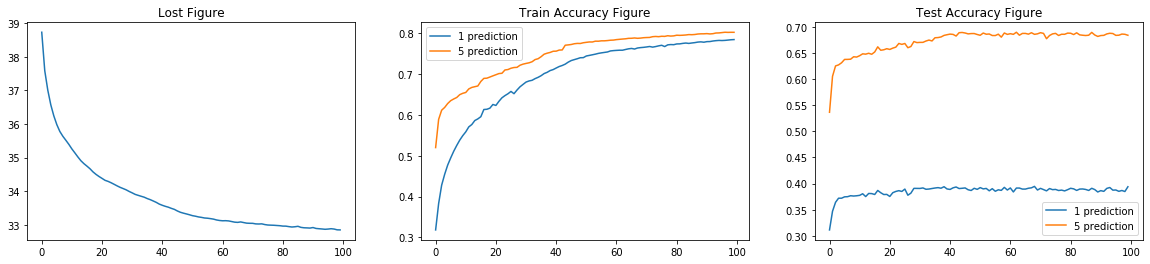

In [0]:
plotAcc(T_lost,T_train1,T_test1,T_train5,T_test5)

Fig3. Tanh activation function accumulative loss figure and accuracy figure

From the above plots, two observations we found are that 1) there is a huge gap between top 5 prediction accuracy and top 1 prediction accuracy, and the gap is only appeared in testing senario. 2) Only for top 1 prediction accuracy, the difference between training accuracy and testing accuracy is large (68% vs 39%).

We suggest that this is due to the nature of images in our dataset. Some image are tooken in poor lighting coditions, some are mixed with many other food, and some correct label is even tricky and hard for human to classify. Also, some food classes are very similar in terms of ingredient and its looks. Therefore, the network trained for training set might not be representitive network for testing set, since there are too many uncertainty and confounding elements, and the influece is most prevail if we considered only top 1 prediction, since top 5 predictions allow more room for the error casued by the above limitations of the images. 

In the next section, we will analysis accuracy for each food class.

### III-3 Accuracy Analysis
In this section, we will show the accuracy results for each fodd class using tanh as the activation function.

In [0]:
#loading all pkl file
with open("drive/My Drive/CV Project/training_data_alexnet.pkl","rb") as f:
    train_data = pickle.load(f)

with open("drive/My Drive/CV Project/test_data_alexnet.pkl","rb") as f:
    test_data = pickle.load(f)
    
with open("drive/My Drive/CV Project/tanh_data.pkl","rb") as f:
    net = pickle.load(f)

#load in food class name, there are 55 different food classes in total
with open('drive/My Drive/CV Project/food-101/meta/labels.txt','r') as f:
    labels = f.readlines()
foodClasses = [label[:-1].replace(" ",'_').lower() for label in labels]
print ("number of food class in the dataset: ", len(foodClasses))

number of food class in the dataset:  55


In [0]:
training_data_dict = {}
for i in range(len(foodClasses)):
    training_data_dict[i] = []

for x in training_data:
    training_data_dict[x[0]].append(x)

test_data_dict = {}
for i in range(len(foodClasses)):
    test_data_dict[i] = []

for x in test_data:
    test_data_dict[x[0]].append(x)

In [0]:
dtype = [('name','U40'),('accuracy',float)]
train_accuracy_dict = np.empty(55, dtype=dtype)

for i in range (0,len(training_data_dict)):
  class_train_data = training_data_dict[i]

  correct = 0
  for label, feature in class_train_data:
      x = Variable(torch.FloatTensor(feature)).cuda()
      output = net(x)
      
      predict_probs = output.cpu().data.numpy()
      prediction_list = np.argsort(predict_probs).squeeze()[-5:]

      if (label in prediction_list):
        correct+=1
      
  train_accuracy_dict[i] = (foodClasses[i],correct/len(class_train_data))

print ("(FOOD, TRAIN ACCURACY)")
train_accuracy_dict = np.sort(train_accuracy_dict,order = 'accuracy')
for food in train_accuracy_dict:
  print (food)

(FOOD, TRAIN ACCURACY)
('falafel', 0.58266667)
('foie_gras', 0.64133333)
('beef_tartare', 0.67733333)
('bread_pudding', 0.69117647)
('ceviche', 0.69866667)
('grilled_salmon', 0.7)
('bruschetta', 0.704)
('chicken_curry', 0.704)
('breakfast_burrito', 0.708)
('french_toast', 0.732)
('carrot_cake', 0.74)
('apple_pie', 0.74933333)
('chocolate_mousse', 0.75866667)
('chicken_quesadilla', 0.764)
('garlic_bread', 0.76666667)
('fried_calamari', 0.76933333)
('escargots', 0.77066667)
('hamburger', 0.77066667)
('gyoza', 0.772)
('chicken_wings', 0.77333333)
('crab_cakes', 0.78266667)
('cheesecake', 0.78533333)
('filet_mignon', 0.78533333)
('baklava', 0.78666667)
('gnocchi', 0.78666667)
('fish_and_chips', 0.78933333)
('guacamole', 0.78933333)
('donuts', 0.8)
('grilled_cheese_sandwich', 0.80933333)
('croque_madame', 0.81466667)
('caprese_salad', 0.816)
('dumplings', 0.81733333)
('cheese_plate', 0.82933333)
('baby_back_ribs', 0.83066667)
('beet_salad', 0.83333333)
('clam_chowder', 0.83466667)
('beef_ca

In [0]:
dtype = [('name','U40'),('accuracy',float)]
test_accuracy_dict = np.empty(55, dtype=dtype)

for i in range (0,len(test_data_dict)):
  class_test_data = test_data_dict[i]
  correct = 0
  for label, feature in class_test_data:
      x = Variable(torch.FloatTensor(feature)).cuda()
      output = net(x)
      
      predict_probs = output.cpu().data.numpy()
      prediction_list = np.argsort(predict_probs).squeeze()[-5:]

      if (label in prediction_list):
        correct+=1
  test_accuracy_dict[i] = (foodClasses[i],correct/len(class_test_data))

print ("(FOOD, TEST ACCURACY)")
test_accuracy_dict = np.sort(test_accuracy_dict,order = 'accuracy')
for food in test_accuracy_dict:
  print (food)

(FOOD, TEST ACCURACY)
('ceviche', 0.468)
('grilled_salmon', 0.484)
('foie_gras', 0.52)
('bruschetta', 0.528)
('garlic_bread', 0.528)
('falafel', 0.548)
('fish_and_chips', 0.548)
('bread_pudding', 0.556)
('apple_pie', 0.56)
('beef_tartare', 0.56)
('filet_mignon', 0.56)
('breakfast_burrito', 0.564)
('chicken_quesadilla', 0.572)
('chocolate_mousse', 0.584)
('french_toast', 0.584)
('croque_madame', 0.6)
('chicken_curry', 0.608)
('caprese_salad', 0.612)
('gyoza', 0.612)
('cheese_plate', 0.62)
('cheesecake', 0.62)
('baby_back_ribs', 0.636)
('hamburger', 0.648)
('baklava', 0.656)
('crab_cakes', 0.66)
('fried_calamari', 0.668)
('chicken_wings', 0.68)
('carrot_cake', 0.684)
('donuts', 0.688)
('gnocchi', 0.688)
('beet_salad', 0.696)
('cannoli', 0.708)
('chocolate_cake', 0.716)
('beignets', 0.724)
('eggs_benedict', 0.728)
('churros', 0.74)
('guacamole', 0.744)
('club_sandwich', 0.752)
('greek_salad', 0.752)
('beef_carpaccio', 0.764)
('caesar_salad', 0.78)
('deviled_eggs', 0.784)
('escargots', 0.7

## IV. Food Classification Experiments
In this section, we uploaded some of the food image we took in our daily life and see how well our network's prediction is. 

In [0]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import json, io, requests, string
import torch.nn.functional as F
import torch

# Load preprocessed testing images from pkl
with open("drive/My Drive/CV Project/testing_data.pkl","rb") as f:
    testing_data = pickle.load(f)

with open("drive/My Drive/CV Project/testing_data2.pkl","rb") as f:
    testing_data2 = pickle.load(f)

In [0]:
def getPrediction(img):
  x = Variable(torch.FloatTensor(img)).cuda()
  predictions = net(x)
  probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
  probs = (-probs).cpu().data.numpy()[0][:5]; indices = indices.cpu().data.numpy()[0][:5]
  preds = [foodClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]
  return ('\n'.join(preds))

### IV-1 Correct Prediction

Text(0.5, 1.0, 'chicken_curry: 0.047508273\nbeef_carpaccio: 0.017778875\nbibimbap: 0.017652437\ngnocchi: 0.017635778\nclub_sandwich: 0.017635778')

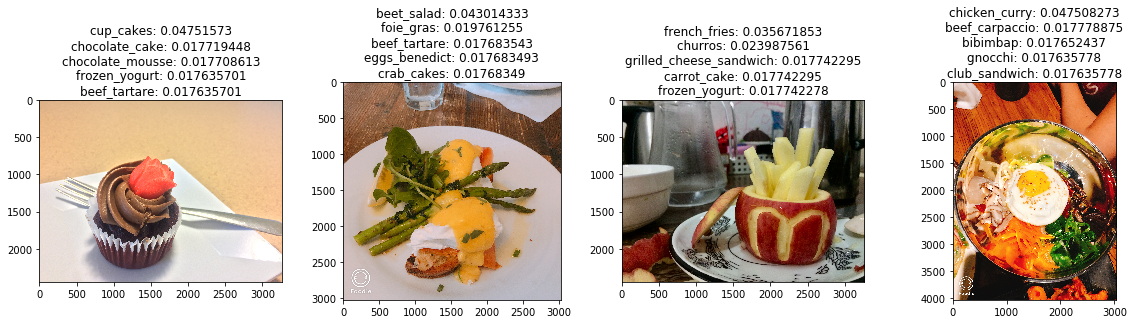

In [0]:
  fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20,4))
  ax1.imshow(Image.open("drive/My Drive/CV Project/pics/cupcake.jpeg"))
  ax1.set_title(getPrediction(testing_data[2]))

  ax2.imshow(Image.open("drive/My Drive/CV Project/pics/egg_benedict.jpeg"))
  ax2.set_title(getPrediction(testing_data[4]))

  ax3.imshow(Image.open("drive/My Drive/CV Project/pics/fries?.jpeg"))
  ax3.set_title(getPrediction(testing_data[5]))

  ax4.imshow(Image.open("drive/My Drive/CV Project/pics/bibimbap.jpeg"))
  ax4.set_title(getPrediction(testing_data[0]))


### IV-2 Incorrect Prediction

Text(0.5, 1.0, 'eggs_benedict: 0.047580656\ncroque_madame: 0.017757261\nbreakfast_burrito: 0.017644377\nbread_pudding: 0.017635051\nfrench_toast: 0.017635016')

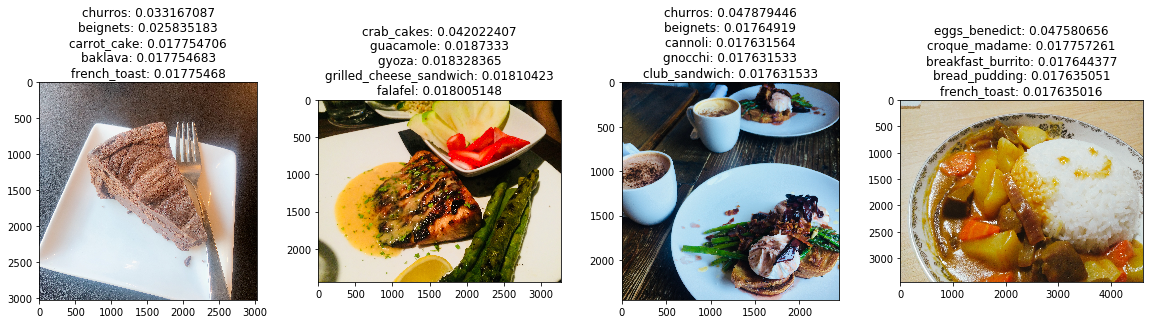

In [0]:
  fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20,4))

  ax1.imshow(Image.open("drive/My Drive/CV Project/pics/chocolate_cake.jpeg"))
  ax1.set_title(getPrediction(testing_data[1]))

  ax2.imshow(Image.open("drive/My Drive/CV Project/pics/grilled_salmon.jpg"))
  ax2.set_title(getPrediction(testing_data2[2]))

  ax3.imshow(Image.open("drive/My Drive/CV Project/pics/eggs_benedict.jpg"))
  ax3.set_title(getPrediction(testing_data[3]))

  ax4.imshow(Image.open("drive/My Drive/CV Project/pics/curry.jpg"))
  ax4.set_title(getPrediction(testing_data2[7]))

Here, we noticed that most incorrect predictions are caused by either 1) there are too many ingredents in the image, or 2) the mispredictions are very close to the actual labelling. For example, the first image in the left, all predictions are some form of baking products.

## V. Calories Analysis

In [0]:
# Load and show calories of each food categories
with open("drive/My Drive/CV Project/food-101/meta/cal.txt","r") as f:
    calories_list = f.readlines()
    calories = []
    for i in calories_list:
      i = i.rstrip("\n")
      calories.append(i)
      print(i)

apple_pie 237cal/100g
baby_back_ribs 248cal/3-ounce
baklava 306cal/serving
beef_carpaccio 181cal/serving
beef_tartare 552cal/serving
beet_salad 598cal/serving
beignets 527cal/3beignets
bibimbap 560cal/bowl
bread_pudding 377cal/200g
breakfast_burrito 657cal/burrito
bruschetta 72cal/piece
caesar_salad 357cal/serving
cannoli 233cal/cannoli
caprese_salad 220cal/serving
carrot_cake 577cal/piece
ceviche 82cal/serving
cheesecake 401cal/piece
cheese_plate 662cal/serving
chicken_curry 243cal/serving
chicken_quesadilla 1069cal/serving
chicken_wings 588cal/6wings
chocolate_cake 352cal/piece
chocolate_mousse 454cal/0.5cup
churros 237cal/churro
clam_chowder 301cal/can
club_sandwich 591cal/sandwich
crab_cakes 160cal/cake
creme_brulee 210cal/serving
croque_madame 889cal/serving
cup_cakes 131cal/cupcake
deviled_eggs 200cal/egg
donuts 195cal/donut
dumplings 80cal/dumpling
edamame 189cal/cup
eggs_benedict 733cal/2eggs
escargots 76cal/3oz
falafel 57cal/patty
filet_mignon 278cal/steak
fish_and_chips 840ca

In [0]:
def getCalores(img):
  x = Variable(torch.FloatTensor(img)).cuda()
  predictions = net(x)
  probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
  probs = (-probs).cpu().data.numpy()[0][:5]; indices = indices.cpu().data.numpy()[0][:5]
  preds = [calories[idx] for (prob, idx) in zip(probs, indices)]
  return ('\n'.join(preds))

Text(0.5, 1.0, 'fried_rice 326cal/item\nfrozen_yogurt 260cap/cup\nguacamole 50cal/2tbsp\ngreek_salad 139cal/item\ndonuts 195cal/donut')

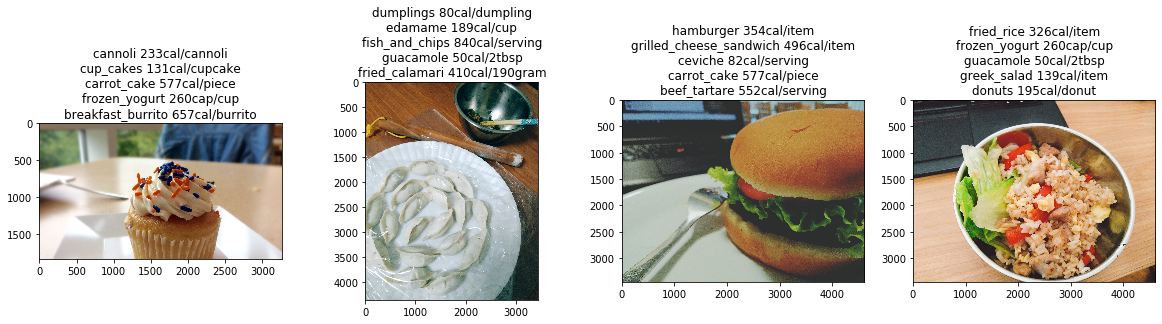

In [0]:
  fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20,4))

  ax1.imshow(Image.open("drive/My Drive/CV Project/pics/cupcake2.jpg"))
  ax1.set_title(getCalores(testing_data2[0]))

  ax2.imshow(Image.open("drive/My Drive/CV Project/pics/dumplings.jpg"))
  ax2.set_title(getCalores(testing_data2[5]))

  ax3.imshow(Image.open("drive/My Drive/CV Project/pics/hamburger.jpg"))
  ax3.set_title(getCalores(testing_data2[6]))

  ax4.imshow(Image.open("drive/My Drive/CV Project/pics/fried_rice.jpg"))
  ax4.set_title(getCalores(testing_data2[8]))

## VI. Reference

For the second part Training and Validating, we took some idea from Github repo: Transfer-Learning-for-Food-Classification by codeLikeMonkey.


https://github.com/codeLikeMonkey/Transfer-Learning-for-Food-Classification

For the fourth part and fifth part Food Classification and Calories Analysis, we took the idea from Assignment 4: *04_CNN_GPU_Assignment*

https://colab.research.google.com/drive/1E3T8Dug9D_5hkH0lx6mfqgNRKq_vQqSr